# Importando bibliotecas

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score



# Lendo dados 

In [2]:
df = pd.read_csv('../data/processed/sample_df_processed.csv')
df['speed'] = df['speed'].astype('str')
df['feed'] = df['feed'].astype('str')

In [3]:
df.dtypes

vibration_x    float64
vibration_y    float64
vibration_z    float64
machine         object
operation       object
description     object
speed           object
feed            object
duration         int64
result           int64
dtype: object

# Separando dados em treino e teste

In [ ]:
X = df.drop(columns=["result"])  
y = df["result"]

# Separando o dataset em treino e teste mantendo a proporção das classes e com uma divisão de 70% para treino e 30% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pre-processamento dos dados 

In [5]:
# DIVISÃO ENTRE COLUNAS CATEGORICAS E NUMERICAS
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

In [6]:
# NORMALIZAR COLUNAS NUMERICAS
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# CODIFICAR COLUNAS CATEGORICAS
categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [7]:
# PRE-PROCESSAMENTO DOS DADOS 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Construindo modelo com dados brutos

## criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [8]:
# CRIANDO O PIPELINE COM OS DADOS PRE-PROCESSADOS E O CLASSIFICADOR
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

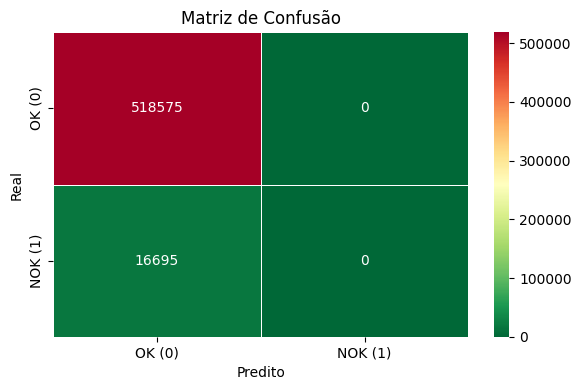

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

1. Pelo gráfico observa-se para o resultado "Bom" o modelo acertou todos mas para valores "Ruim";
2. Provavelmente o desbalanceamento dos dados causa isso.

## Avaliando métricas

In [10]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.drop(columns=['support'])
report_df.head(3)

,precision,recall,f1-score
0,0.96881,1.00000,0.984158
1,0.00000,0.00000,0.000000
accuracy,0.96881,0.96881,0.968810


Como esperando no relatório das métricas observamos:
1. Para resultado "Bom" o modelo tem boa precisão (96,9% de acerto), recall, f1-score;
2. Para o resultado "Ruim" o modelo não acertou nenhuma então tem precisão ruim (0% de acerto), recall;
3. Quando olhamos em termos gerais o modelo apresenta boas nos notas mas causadaos pelo inviesamento do dado que tem maior representatividade.

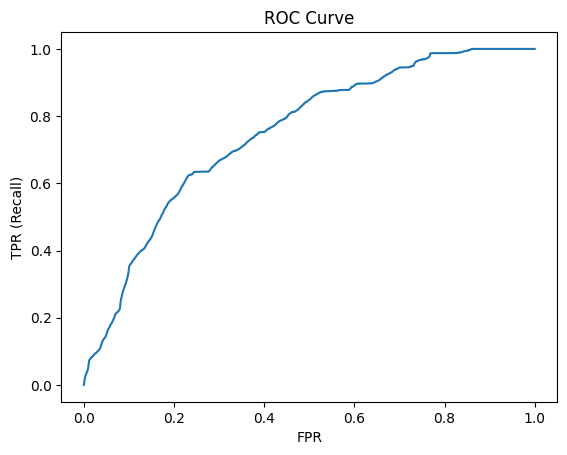

AUC: 0.75


In [36]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")	

Pela curva ROC observamos:
1. A curva não sobe rápido o que indica dificuldade em separar as classes.
2. O modelo não é muito discriminativos por isso necessita muitos falsos positivos para acertart os reais positivos.
3. o Valor de AUC é bom mas por causa do desbalanceamento.
   

## Importância das variáveis

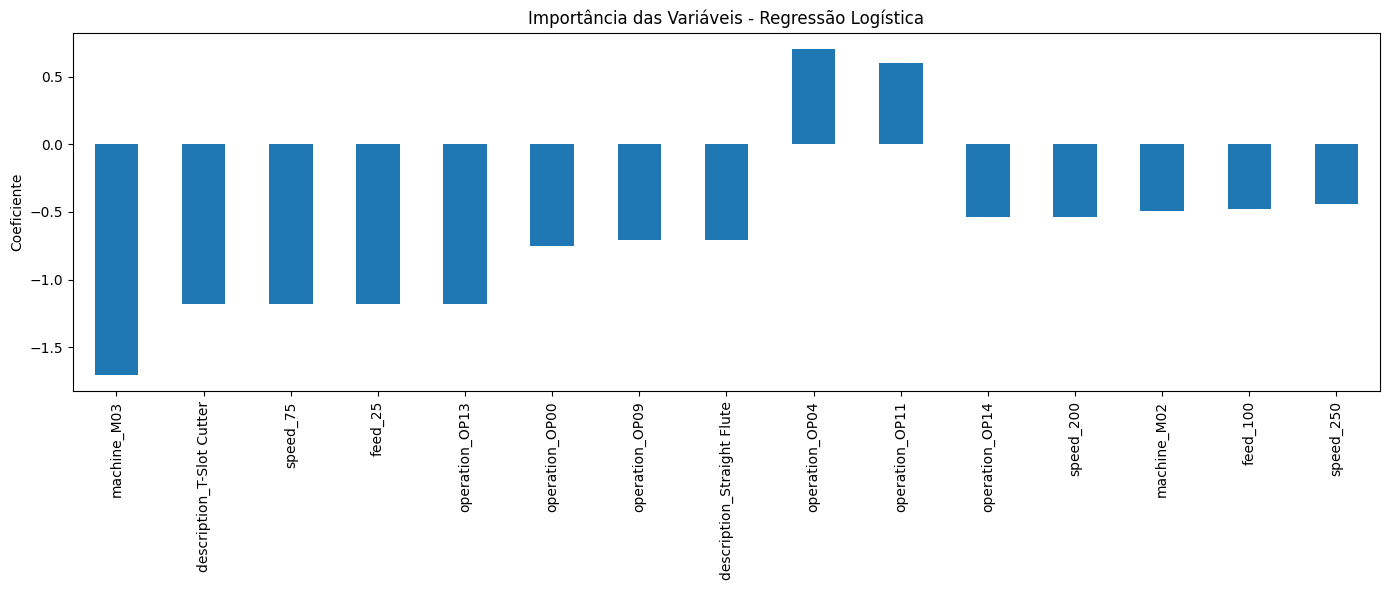

In [37]:
model = pipeline.named_steps['classifier']

preprocessor = pipeline.named_steps['preprocessor']

def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)

    return feature_names

feature_names = get_feature_names(preprocessor)

coefficients = model.coef_[0]

feature_importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(14, 6))
feature_importance.head(15).plot(kind='bar')  
plt.title("Importância das Variáveis - Regressão Logística")
plt.ylabel("Coeficiente")
plt.tight_layout()
plt.show()


## Resultados

1. O modelo é melhor que o aleatório mas ainda não é recomendado;
2. A tendência do modelo é sempre classificar como "bom" e assim errar pouco o que traz um vies muito ruim;
3. Proximos passos é testar balanceando os dados e verificando outros algoritmos.

# Construindo modelo com dados balanceados

## criando pipeline utilizando preprocessamento dos dados e utilizando a algoritmo de regressão logistica

In [16]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000))
])


pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

## Criando matriz de confusão

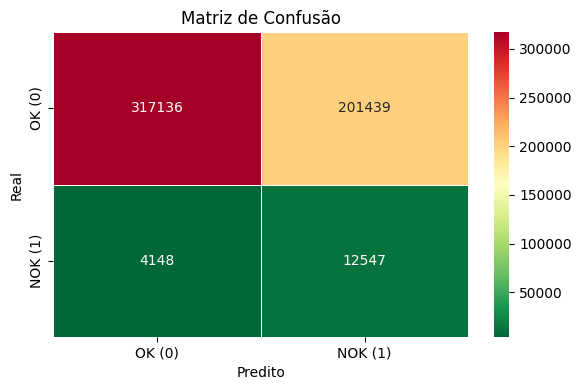

In [17]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="RdYlGn_r",
    linewidths=0.5,
    xticklabels=["OK (0)", "NOK (1)"],
    yticklabels=["OK (0)", "NOK (1)"]
)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

Ao balancear os dados foi visto:
1. Houveram uma proporção boa entre TP e FN
2. A relação entre TN e FP melhorou mas valores ainda ruins o que faz indicar muitos resultados "Bom" como "Ruim"

## Avaliando métricas

In [23]:
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df.head(3)

,precision,recall,f1-score,support
0,0.987089,0.611553,0.755212,518575.000000
1,0.058635,0.751542,0.108782,16695.000000
accuracy,0.615919,0.615919,0.615919,0.615919


Como esperando no relatório das métricas observamos:
1. Para resultado "Bom" o modelo tem boa precisão (98,7% de acerto) contudo o recall caiu (38,9% dos dados "Bom" estão classificados como "Ruim") e consequentemente f1-score também caiu;
2. Para o resultado "Ruim" o modelo começou a ter resultados com um recall bom (Detectou 75% das falhas) mas a precisão está muito baixa ainda ();
3. Quando olhamos em termos gerais o modelo apresenta boas nos notas mas causadaos pelo inviesamento do dado que tem maior representatividade.

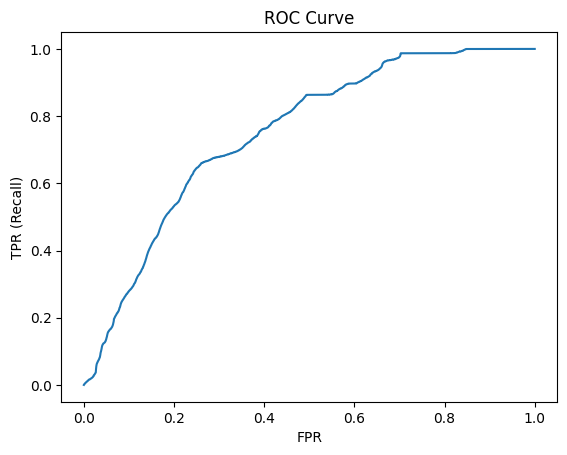

AUC: 0.75


In [25]:
y_proba = pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_proba)


fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("ROC Curve")
plt.show()
print(f"AUC: {auc:.2f}")




# Importância das features

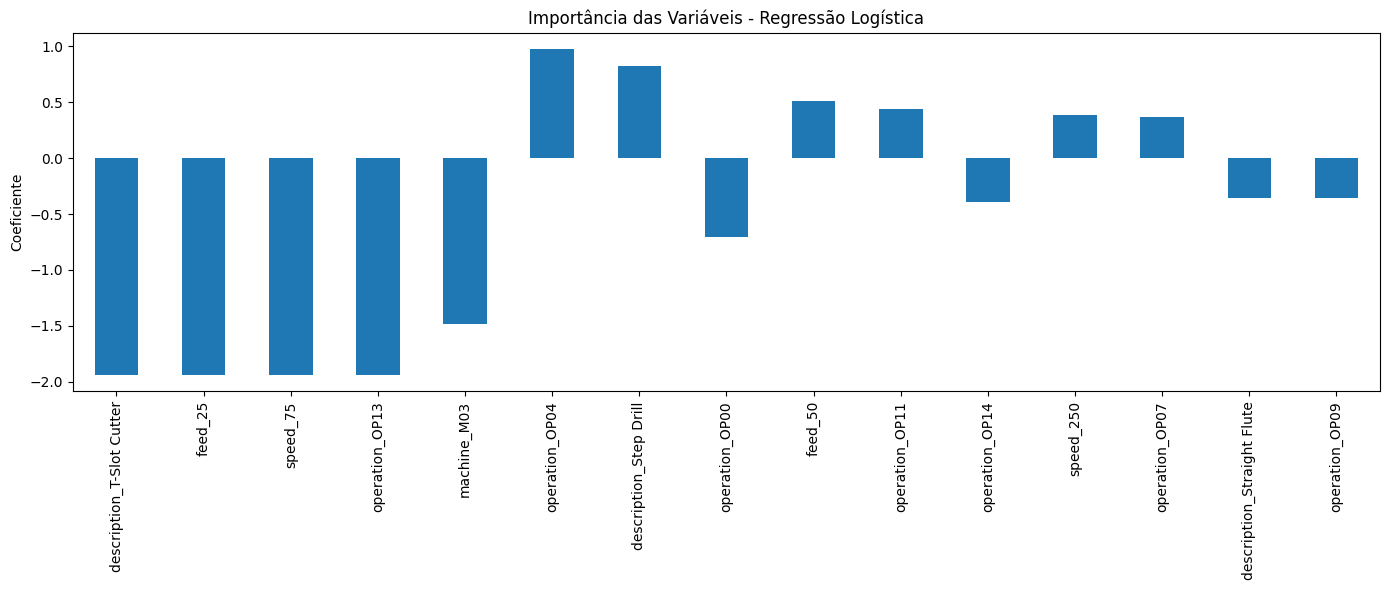

In [22]:
model = pipeline.named_steps['classifier']

preprocessor = pipeline.named_steps['preprocessor']

def get_feature_names(preprocessor):
    feature_names = []

    for name, transformer, cols in preprocessor.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
        feature_names.extend(names)

    return feature_names

feature_names = get_feature_names(preprocessor)

coefficients = model.coef_[0]

feature_importance = pd.Series(coefficients, index=feature_names).sort_values(key=abs, ascending=False)

plt.figure(figsize=(14, 6))
feature_importance.head(15).plot(kind='bar')  
plt.title("Importância das Variáveis - Regressão Logística")
plt.ylabel("Coeficiente")
plt.tight_layout()
plt.show()
